In [160]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

<hr />

### ⦿ Enhancing

In [161]:
imgRaw = cv.imread("sunsetDrive.jpg")

Changes the channels so they are in the same order as the original image

In [162]:
imgOriginal = cv.cvtColor(imgRaw, cv.COLOR_BGR2RGB)

Function for easier plotting of the image and its respective intensity histogram

In [163]:
def plotImageWithIntensityHist(image, title):

    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
 
    cdf = hist.cumsum()
    cdfNorm = cdf * float(hist.max()) / cdf.max()
 
    fig, ax = plt.subplots(1, 2, figsize=(12.5,5))

    ax[0].imshow(image)

    ax[1].plot(cdfNorm)
    ax[1].hist(image.flatten(), 256, [0, 256])
    ax[1].legend(("cdf", "histogram"), loc = "upper left")
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

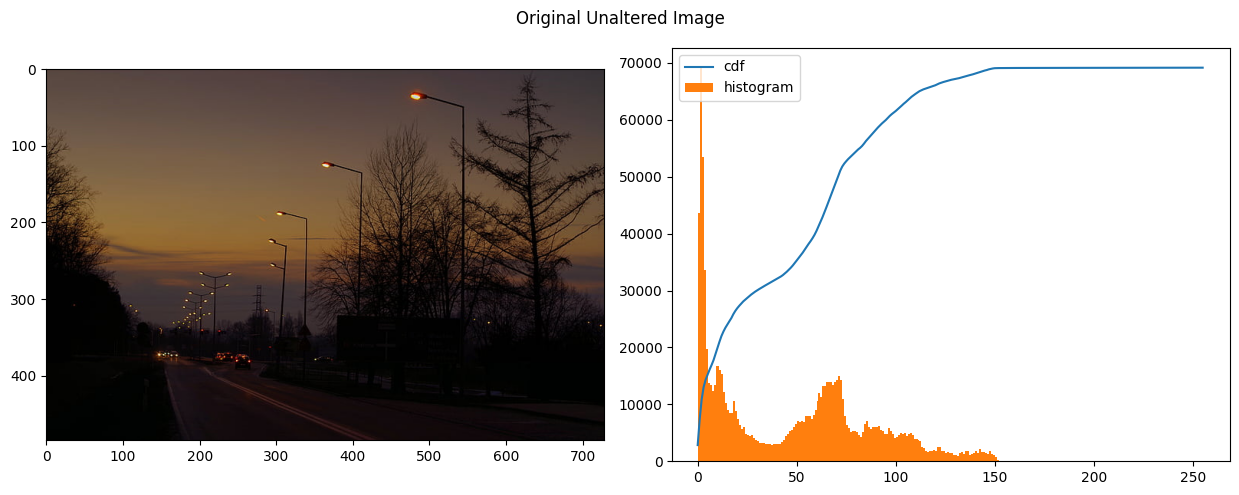

In [164]:
plotImageWithIntensityHist(imgOriginal, "Original Unaltered Image")

#### ◙ ◙ Histogram Equalization

##### Independent Equalization on All Channels

In [165]:
rgbChannels = cv.split(imgOriginal)

rgbChannelsEqualized = [cv.equalizeHist(ch) for ch in rgbChannels]
imgOriginal_Equalized = cv.merge(rgbChannelsEqualized)

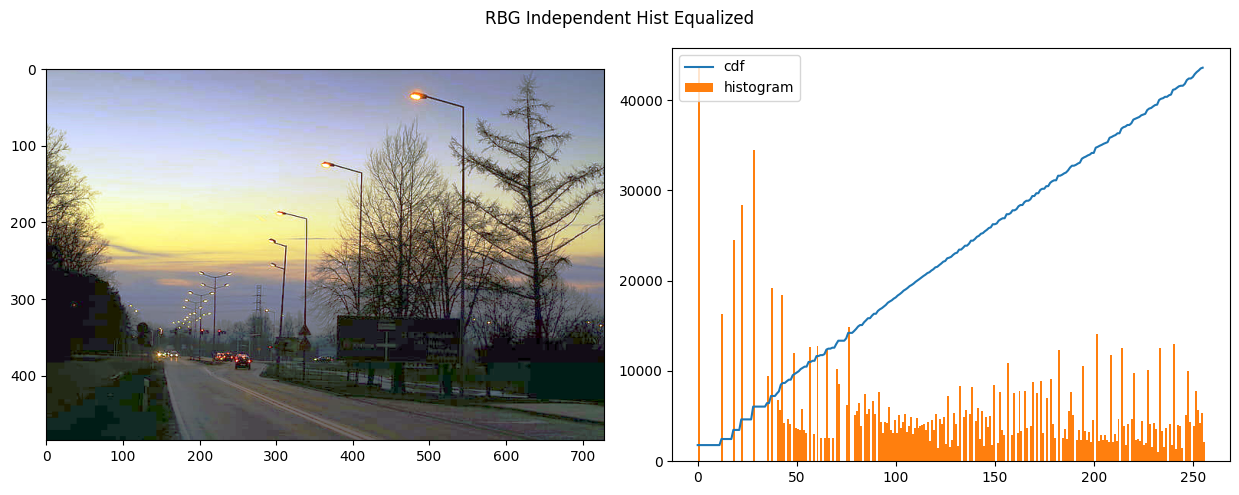

In [166]:
plotImageWithIntensityHist(imgOriginal_Equalized, "RBG Independent Hist Equalized")

##### Equalization on V Channel

In [167]:
imgHSV = cv.cvtColor(imgRaw, cv.COLOR_BGR2HSV)

In [168]:
h, s, v = cv.split(imgHSV)
vEqualized = cv.equalizeHist(v)
imgHSV = cv.merge([h, s, vEqualized])
imgEqualized_vChannel = cv.cvtColor(imgHSV, cv.COLOR_HSV2RGB)

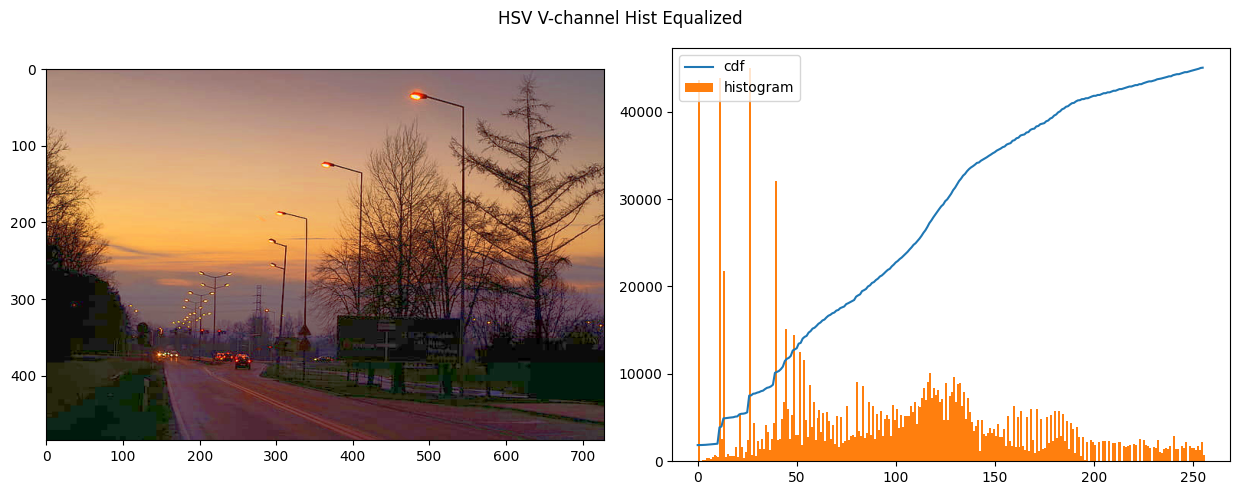

In [169]:
plotImageWithIntensityHist(imgEqualized_vChannel, "HSV V-channel Hist Equalized")

#### ◙ ◙ Gamma Enhancing

##### Low Intensity Areas (gamma > 1)

In [170]:
gamma = 2
table = np.array([(i / 255.0) ** (1 / gamma) * 255 for i in range(256)]).astype("uint8")

imgOriginal_LowIntEnhanced =  cv.LUT(imgOriginal, table)

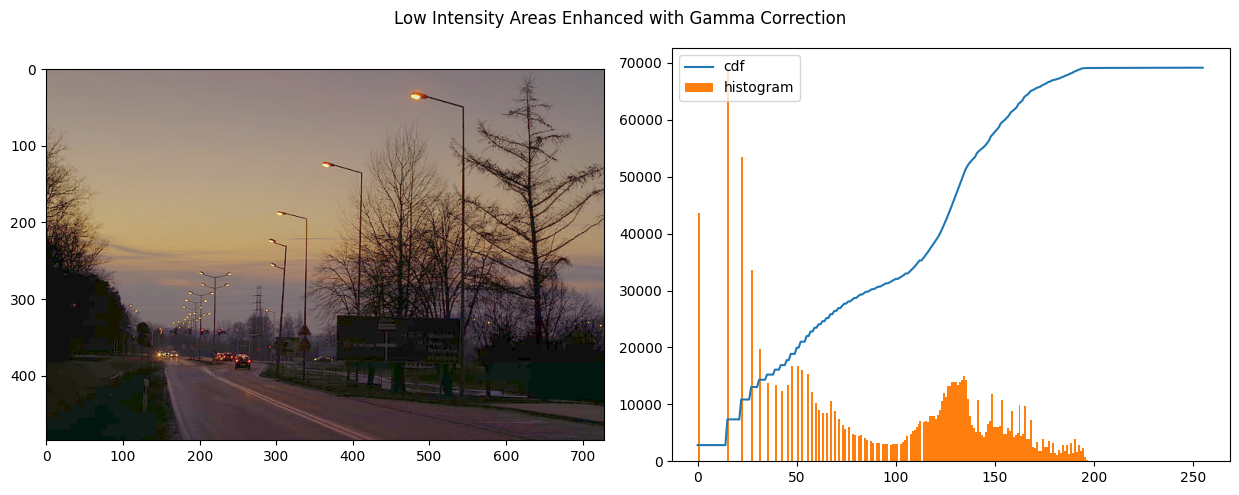

In [171]:
plotImageWithIntensityHist(imgOriginal_LowIntEnhanced, "Low Intensity Areas Enhanced with Gamma Correction")

##### High Intensity Areas (gamma \< 1)

In [172]:
gamma = 0.5
table = np.array([(i / 255.0) ** (1 / gamma) * 255 for i in range(256)]).astype("uint8")

imgOriginal_HighIntEnhanced =  cv.LUT(imgOriginal, table)

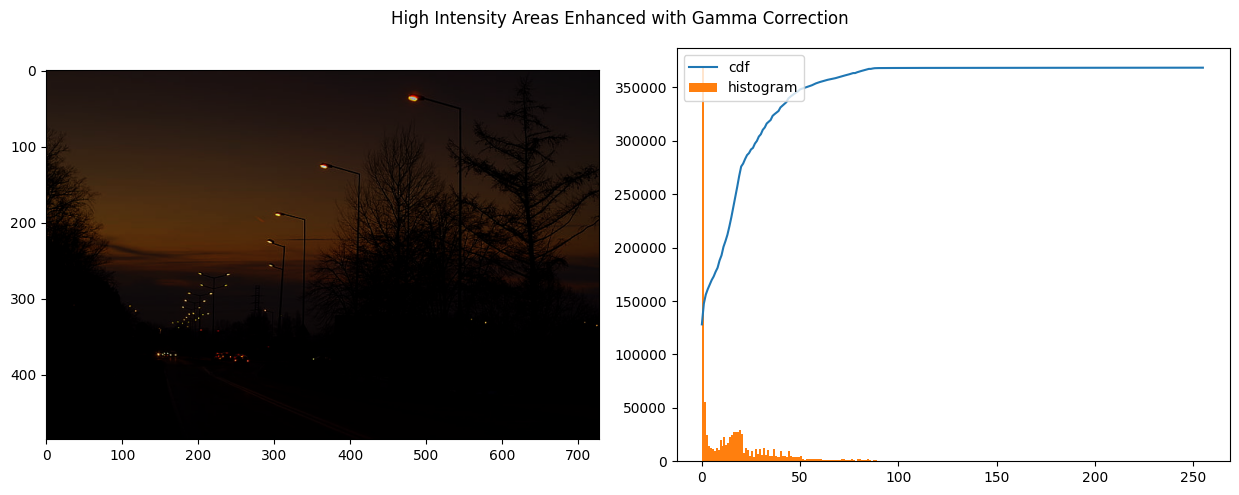

In [173]:
plotImageWithIntensityHist(imgOriginal_HighIntEnhanced, "High Intensity Areas Enhanced with Gamma Correction")

<hr />

### ⦿ Edge Detection

In [174]:
#imgRaw = cv.imread("mclovin.jpg")

Changes the channels so they are in the same order as the original image

In [175]:
#imgOriginal = cv.cvtColor(imgRaw, cv.COLOR_BGR2RGB)